# Reinforcement Learning project:
This file is used to test some util functions that will be implemented either in the `train.py` file or in another file (maybe `utils.py`).

In [1]:
from gymnasium.wrappers import TimeLimit
from env_hiv import HIVPatient
import numpy as np

In [2]:
env = TimeLimit(
    env=HIVPatient(domain_randomization=False), max_episode_steps=200
)
print(env.observation_space)
print(env.action_space)

Box(-inf, inf, (6,), float32)
Discrete(4)


## Description of the environment:
- **States:** each state is represented by a 6 dimensional vector, each one containing values in $\mathbb{R}$ (further refinements can be added to the model after completing our first steps).
- **Actions:** There are 4 actions in total.

## Dataset:

Let us us the function `create_dataset`implemented in the file `data.py` to generate a dataset of $1M$ samples of the form: $(s, a, r, s', d)$

--> Should run this on a gpu using tmux

In [10]:
# from data import *
# horizon = int(1e6)
# dataset = create_dataset(env, horizon)


## Random Forest Regressor

In [27]:
from tqdm.auto import tqdm
from data import *
from sklearn.ensemble import RandomForestRegressor

In [28]:
# Load the data
dataset = load_dataset("data.npz")
S, A, R, S2, D = dataset.values()

In [29]:
def rf_fqi(S, A, R, S2, D, iterations, nb_actions, gamma, disable_tqdm=False):
    nb_samples = S.shape[0]
    Qfunctions = []
    SA = np.append(S,A,axis=1)
    for iter in tqdm(range(iterations), disable=disable_tqdm):
        if iter==0:
            value=R.copy()
        else:
            Q2 = np.zeros((nb_samples,nb_actions))
            for a2 in range(nb_actions):
                A2 = a2*np.ones((S.shape[0],1))
                S2A2 = np.append(S2,A2,axis=1)
                Q2[:,a2] = Qfunctions[-1].predict(S2A2) # Using the previous q function to predict next one
            max_Q2 = np.max(Q2,axis=1)
            value = R + gamma*(1-D)*max_Q2
        Q = RandomForestRegressor()
        Q.fit(SA,value)
        Qfunctions.append(Q)
    return Qfunctions

In [30]:
gamma = .9
nb_iter = 200
nb_actions = 4
Qfunctions = rf_fqi(S, A, R, S2, D, nb_iter, nb_actions, gamma)

  1%|          | 2/200 [00:22<37:41, 11.42s/it]


KeyboardInterrupt: 

In [20]:
# Save and Load the model
import joblib

# Save the model
joblib.dump(Qfunctions[-1], "random_forest_regressor.pkl")

# Load the model
loaded_model = joblib.load("random_forest_regressor.pkl")

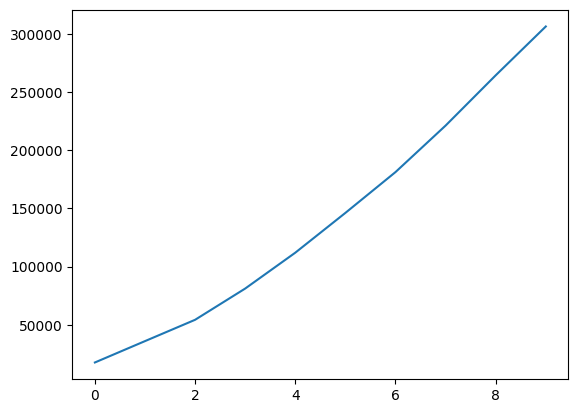

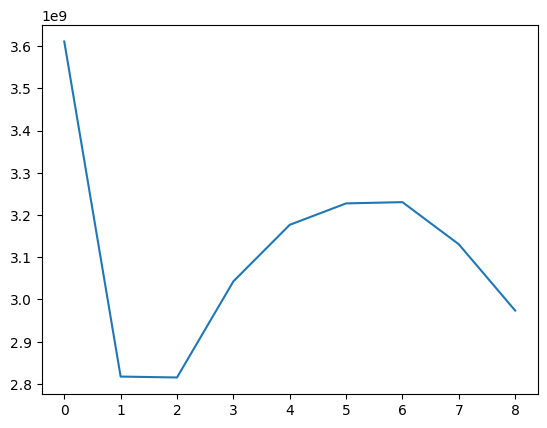

In [21]:
import matplotlib.pyplot as plt

# Value of an initial state across iterations
s0,_ = env.reset()
Vs0 = np.zeros(nb_iter)
for i in range(nb_iter):
    Qs0a = []
    for a in range(4):
        s0a = np.append(s0,a).reshape(1, -1)
        Qs0a.append(Qfunctions[i].predict(s0a))
    Vs0[i] = np.max(Qs0a)
plt.plot(Vs0)

# Bellman residual
residual = []
SA = np.append(S,A,axis=1)
for i in range(1,nb_iter):
    residual.append(np.mean((Qfunctions[i].predict(SA)-Qfunctions[i-1].predict(SA))**2))
plt.figure()
plt.plot(residual);

In [25]:
print(np.max(R))
print(np.min(R))

288386.7799974587
-16264.124379701298


### Need to do some Data Preprocessing !

In [2]:
N = 100  # Replace with the desired number of rows
from data import load_dataset
dataset = load_dataset("data_1M.npz")
S, A, R, S2, D = (arr[:N] for arr in dataset.values())


In [3]:
S.shape

(100, 6)

In [5]:
import numpy as np
k = np.random.choice(np.arange(0, 4))
k

np.int64(0)